In [1]:
import sys
import pathlib
sys.path.insert(0, str(pathlib.Path(
).resolve().parent)) #.. this has to be the folder reCNN_visual_prosthesis
import wandb
import glob
from models import reCNN_bottleneck_CyclicGauss3d, reCNN_bottleneck_CyclicGauss3d_no_scaling, Lurz_Control_Model
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torchvision.transforms as transforms
import math
from Antolik_dataset import AntolikDataset, AntolikDataModule
from experiments.utils import pickle_read, download_model, get_neuron_estimates, reconstruct_orientation_maps, visualize_preferred_orientations, rotate_and_compute_distances, circular_distance
import pytorch_lightning as pl
import torch
from model_trainer import run_wandb_training
from energy_model.energy_model import EnergyModel, EnergyModelIndividual
from train_on_antolik import get_config
from model_trainer import Antolik_dataset_preparation_function, get_model

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from experiments.utils import pickle_read, download_model

In [2]:
ENTITY = "csng-cuni"
PROJECT = "reCNN_visual_prosthesis"

model = None


##################################################################
# MODEL
needs_ground_truth = False
model_needs_dataloader = True
init_to_ground_truth_positions = False
init_to_ground_truth_orientations = False
do_not_sample = True # POZOR

# TRAINING
train_on_test = True
max_epochs = 500
max_time = 4
patience = 7
train_on_val = False
test = True
seed = 42
batch_size = 10
lr = 0.001

# DATASET
# brain_crop = 0.5 #None # 0.8
brain_crop = None #None # 0.8
# brain_crop = None
stimulus_crop = None # "auto" or [110, 110]

# only on of these can be True (or neither of them), if both were, it would be a double negation and reCNN would be set to the same y as the ground truth 
# negative_y_coordinate = True # this says that readout has to put minus in front of y
positions_minus_y = True # this says that dataset has to put minus in front of y when loading the ground truth
positions_minus_x = False # this says that dataset has to put minus in front of y when loading the ground truth


################################################################

config = get_config(
    needs_ground_truth,
    model_needs_dataloader,
    init_to_ground_truth_positions,
    init_to_ground_truth_orientations,
    do_not_sample,
    train_on_test,
    max_epochs,
    max_time,
    patience,
    train_on_val,
    test,
    seed,
    batch_size,
    lr,
    brain_crop,
    stimulus_crop,
    positions_minus_x=positions_minus_x,
    positions_minus_y=positions_minus_y,
)

In [3]:
config["train_data_dir"] = "/storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik_reparametrized/one_trials.pickle"
config["test_data_dir"] = "/storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik_reparametrized/ten_trials.pickle"

In [4]:
dm = Antolik_dataset_preparation_function(config, load_data=True)

Data loaded successfully!
Loaded precomputed mean from /storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik_reparametrized/ten_trials_mean.npy


In [17]:
a = next(iter(dm.train_dataloader()))

In [46]:
class TrainableImage(pl.LightningModule):
    def __init__(self, image_size, enc, min_pixel_value=-1.757, max_pixel_value=2.0408):
        super().__init__()
        self.image_size = image_size
        self.min_pixel_value = min_pixel_value
        self.max_pixel_value = max_pixel_value

        if type(enc) == type("a"):
            self.set_encoder(enc)
        else:
            self.encoder = enc
        
        self.weights = torch.nn.Parameter(data=torch.rand((self.image_size, self.image_size)))
        for param in self.encoder.parameters():
            param.requires_grad = False
    
    def forward(self, x): # x are just ones
        
        x = x * self.weights

        mean = torch.mean(x)
        std = torch.std(x)
        x = (x - mean) / std
        x = torch.clip(x, min=self.min_pixel_value, max=self.max_pixel_value)
        
        x = self.encoder(x)
        return x[:,0]

    def training_step(self, batch, batch_idx):
        x, y = batch
        loss = -torch.mean(self(x))
        return loss
    
    def set_encoder(self, artifact_name):
        self.encoder = download_model(artifact_name=artifact_name, model_class=Lurz_Control_Model)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

im = TrainableImage(image_size=110, enc="StackedCore_FullGaussian2d:v1878")

wandb: wandb version 0.13.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Global seed set to 42


Model from ./artifacts/StackedCore_FullGaussian2d:v1878/epoch=12-step=5199.ckpt loaded!


/opt/conda/lib/python3.8/site-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")
/opt/conda/lib/python3.8/site-packages/neuralpredictors/layers/cores/conv2d.py:128: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)


In [47]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class OnesDataset(Dataset):
    def __init__(self, size=110, length=1000):

        self.size = size
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx): 
        """
            This is the critical method in this class. It allows us to get 
            an instance by an id.
        """
        ones = torch.ones(1, self.size, self.size)

        return ones, 0
    
class OneImageDataModule(pl.LightningDataModule):
    def __init__(self, size=110, batch_size=10):
        super().__init__()
        self.size = size
        self.batch_size = batch_size

    def setup(self):
        self.train = OnesDataset(self.size, 1000)
        self.val = OnesDataset(self.size, 10)
        self.test = OnesDataset(self.size, 1000)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size)


In [48]:
dm = OneImageDataModule(size=110, batch_size=100)
dm.setup()

In [49]:
trainer = pl.Trainer(
    callbacks=[],
    max_epochs=10,
    gpus=[0],
    logger=False,
    log_every_n_steps=100,
    enable_checkpointing=True,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [50]:
trainer.fit(
    im,
    train_dataloaders=dm.train_dataloader(),
    val_dataloaders=dm.val_dataloader(),
)

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:116: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-e8f2ab5c-0440-2a4f-ed6c-dbcc17039599]

  | Name    | Type               | Params
-----------------------------------------------
0 | encoder | Lurz_Control_Model | 1.0 M 
-----------------------------------------------
12.1 K    Trainable params
1.0 M     Non-trainable params
1.0 M     Total params
4.136     Total estimated model params size (MB)
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /auto/budejovice1/mpicek/reCNN_visual_prosthesis/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/opt/conda/lib/python3.

Epoch 9: 100%|██████████| 10/10 [00:01<00:00,  7.34it/s, loss=-96.5]


In [51]:
w = im.weights
w = w.cpu().detach().numpy()

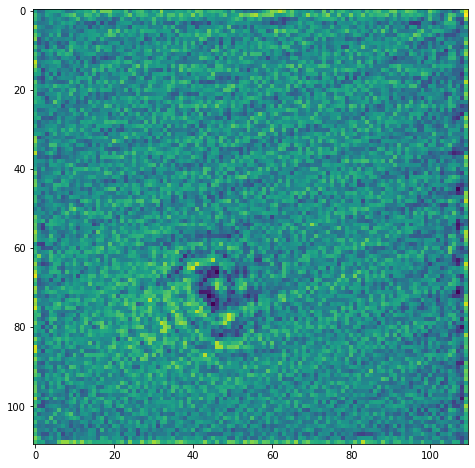

In [52]:
plt.figure(figsize = (8,8))
plt.imshow(w2)